# SOM for SL and Brown and Bruzual Charlot PCA coefficients


- author : Sylvie Dagoret-Campagne
- affiliation  : IJCLab
- creation date : 2023/01/17
- last update : 2023-01-17

- Intuitive introduction to SOM in youtube : https://www.youtube.com/watch?v=lFbxTlD5R98


- https://github.com/JustGlowing/minisom
- https://github.com/JustGlowing/minisom/blob/master/examples/Clustering.ipynb
- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb
- https://github.com/JospehCeh/PhotoZ_PhD/tree/u/dagoret

https://heartbeat.comet.ml/introduction-to-self-organizing-maps-soms-98e88b568f5d

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from sklearn_som.som import SOM
from minisom import MiniSom
from sklearn.decomposition import PCA

/Users/dagoret/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%matplotlib inline
import os
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))
import copy
from itertools import cycle

In [4]:
from astropy.io import fits
import pickle

In [5]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.left': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)


## Start

In [6]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/SOM


## Config

### Check convergence

In [7]:
FLAG_CHECK_CONVERGENCE = False   # check if the number of iteration is OK
FLAG_VIEW_CLUSTERING = True      # View the result of clustering
FLAG_PCA_ONCLUSTERS =True        # Do PCA inside each cluster

## Read input file

### Choose the type of input:

- infile_idx=0 : StarLight
- infile_idx=1 : Brown
- infile_idx=2 : Bruzual-Charlot

In [8]:
all_filenames = ['datatools/pcamethod1_SL_eigenvectorandcoeff.fits',
                 'datatools/pcamethod1_Brown_eigenvectorandcoeff.fits',
                 'datatools/pcamethod1_BruzualCharlot_eigenvectorandcoeff.fits']
all_filenames_labels = ["StarLight","Brown","Bruzual-Charlot"]
all_filenames_tags = ["SL","BR","BC"]


# choose the SED type
infile_idx=2

the_filename_label = all_filenames_labels[infile_idx]
the_filename_tag = all_filenames_tags[infile_idx]

filename = all_filenames[infile_idx]
hdu = fits.open(filename)
hdu.info()

Filename: datatools/pcamethod1_BruzualCharlot_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (10002, 86)   float64   
  1                1 ImageHDU         8   (10, 83)   float64   
  2                1 ImageHDU         8   (10001, 10)   float64   


### Read Spectra

In [9]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                10002                                                  
NAXIS2  =                   86                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of Brown                                                        

### Read PCA coefficients

In [10]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                   83                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

### Read PCA eigenvectors

In [11]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                10001                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

## Decode data

### Decode spectra data

In [12]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 

### Decode PCA data

In [13]:
X = copy.deepcopy(data2[:,:])

# Normalize the data

- I think one should not standardize PCA coefficients

In [14]:
#X = (spec - np.mean(spec, axis=0)) / np.std(spec, axis=0)

# SOM

- The best Intuitive introduction to SOM can be found in  youtube : https://www.youtube.com/watch?v=lFbxTlD5R98 in Kimia lab chain

### SOM principle and initialisation

Input: dataset, size and topology of the map

Output: the codebook for each output node

        Randomize the map’s nodes weight
        Select randomly one instance
        Find the closest node: best matching unit
        The codebook of this node is updated
        The codebooks of the adjacent nodes are also updated, by not to the same degree
        Reduce the intensity of the update progressively
        Repeat 1 to 6 for Tmax iterations

Weight update rule for a node
, knowing that

is the winning node:

: learning rate

: neighbourhood function
where

is the euclidian distance between node i and j on Kohonen (flat-2D ) map

and

    are hyperparameters



- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb

In [15]:
# Initialization and training

n_neurons = 70
m_neurons = 70

learning_rate_0=0.5
sigma_0 = 12
Niter = 500

#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=1.5, learning_rate=.1, neighborhood_function='gaussian', random_seed=0)
#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5, neighborhood_function='gaussian', random_seed=0)
som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=sigma_0, learning_rate=learning_rate_0, neighborhood_function='gaussian', random_seed=0)
              
    
som.pca_weights_init(X)
som.train(X, Niter, verbose=True)  # random training

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.00022303206201789282


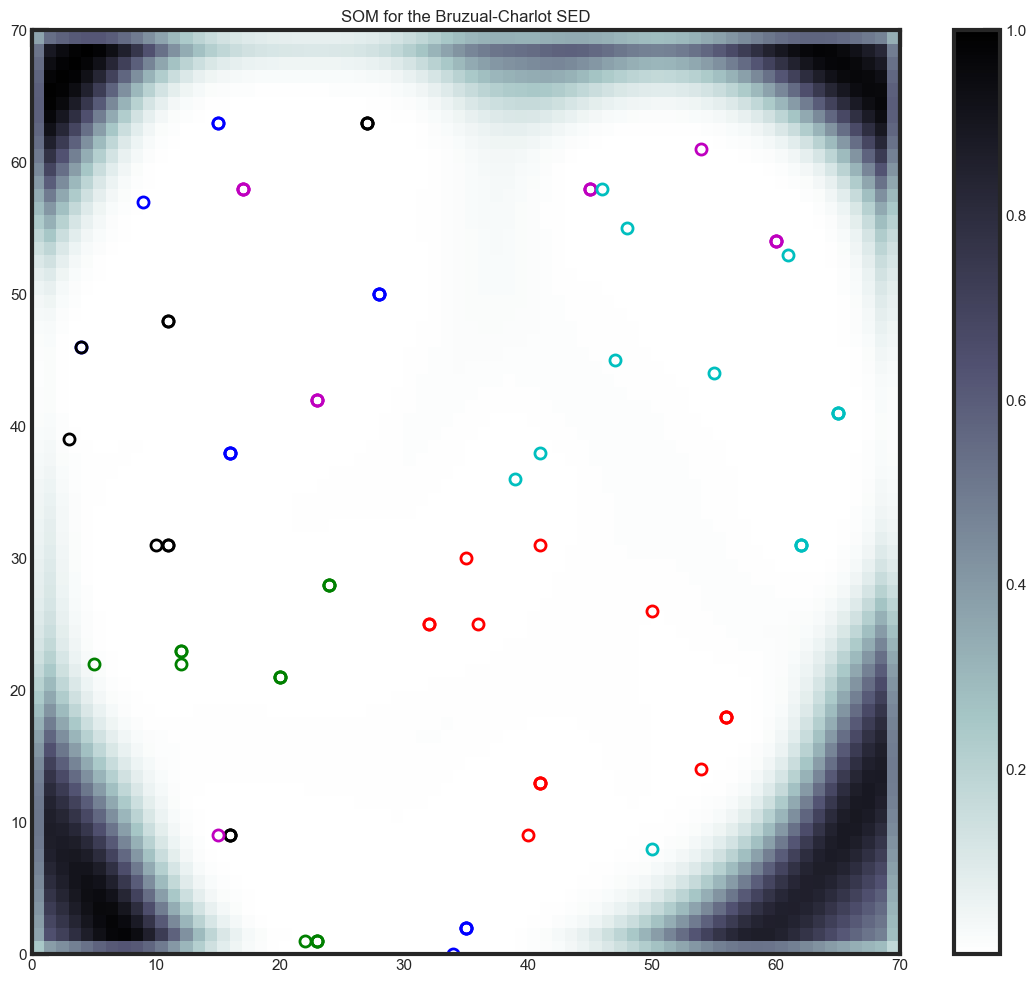

In [16]:
cycol = cycle('bgrcmk')

plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label

for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0], w[1], 'o', markerfacecolor='None',markeredgecolor=next(cycol), markersize=8, markeredgewidth=2)

    
the_title = f"SOM for the {the_filename_label} SED" 
plt.title(the_title)
plt.show()



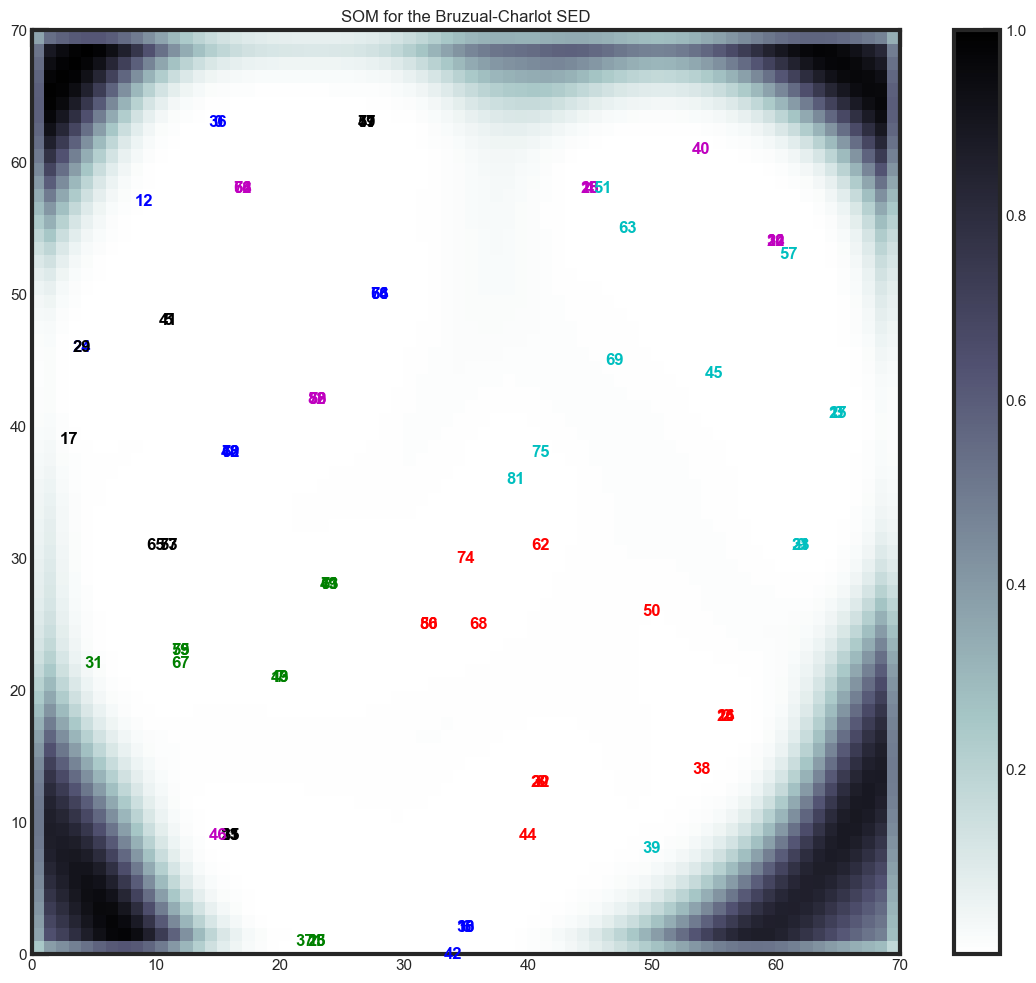

In [17]:
cycol = cycle('bgrcmk')

plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label

for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    #plt.plot(w[0], w[1], 'o', markerfacecolor='None',markeredgecolor='r', markersize=5, markeredgewidth=2)
    the_num=int(all_numbers[cnt])
    plt.text(w[0],w[1],the_num, color=next(cycol),ha="center", va="center",fontsize=12,fontweight='bold')
plt.title(the_title)
plt.show()


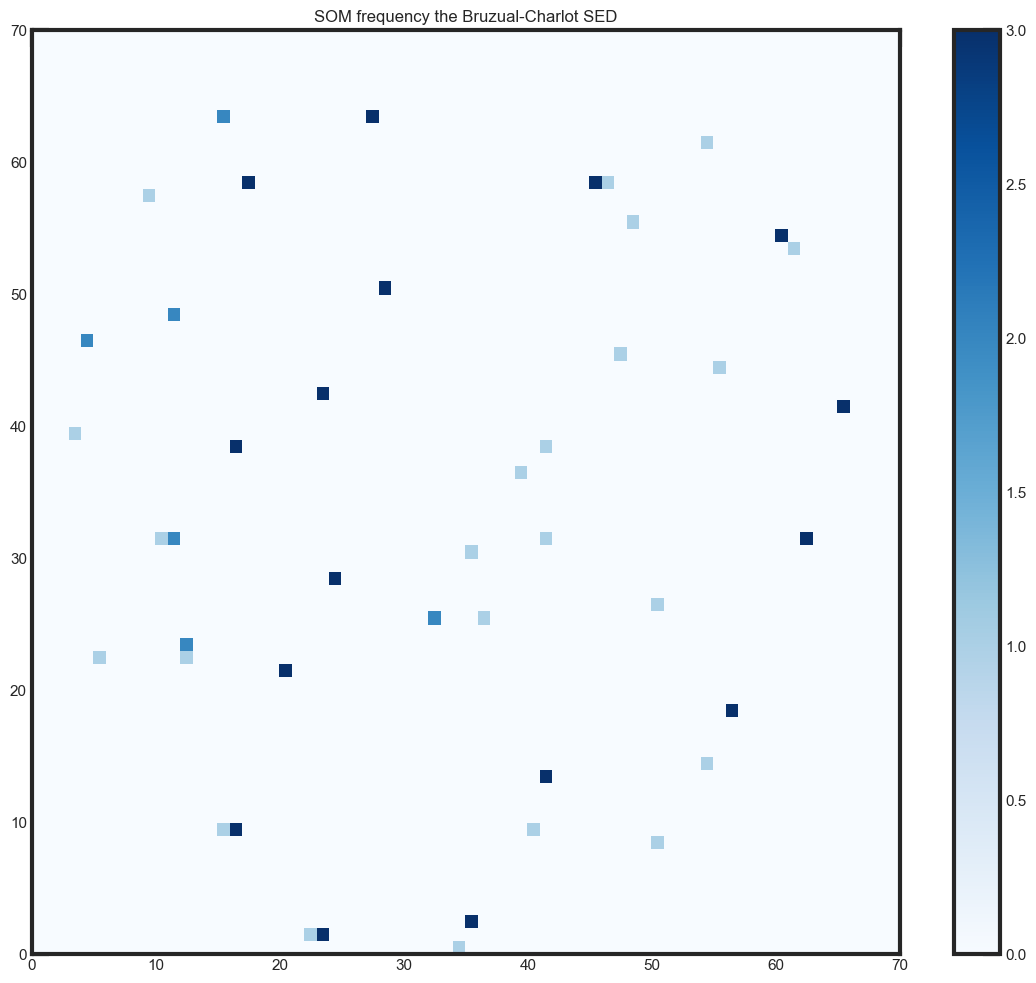

In [18]:
plt.figure(figsize=(14, 12))
frequencies = som.activation_response(X)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
the_title = f"SOM frequency the {the_filename_label} SED" 
plt.title(the_title)
plt.show()


## Clustering on SOM

In [19]:
from sklearn.cluster import KMeans

In [20]:
if not FLAG_VIEW_CLUSTERING:
    assert False

In [21]:
all_positions = []
for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    all_positions.append(w)
all_positions=np.vstack(all_positions)

In [22]:
X1=all_positions

In [23]:
n_clu = 50
km = KMeans(n_clusters = n_clu)
estimator = km.fit(X1)
print("centroids: ", km.cluster_centers_)
print("labels: ", km.labels_)
N=X1.shape[0] 

centroids:  [[60. 54.]
 [32. 25.]
 [17. 58.]
 [16.  9.]
 [56. 18.]
 [ 4. 46.]
 [ 5. 22.]
 [34.  0.]
 [28. 50.]
 [45. 58.]
 [65. 41.]
 [11. 31.]
 [39. 36.]
 [41. 13.]
 [24. 28.]
 [27. 63.]
 [23.  1.]
 [62. 31.]
 [47. 45.]
 [54. 61.]
 [11. 48.]
 [16. 38.]
 [23. 42.]
 [20. 21.]
 [12. 22.]
 [50.  8.]
 [50. 26.]
 [15. 63.]
 [ 3. 39.]
 [55. 44.]
 [ 9. 57.]
 [35. 30.]
 [54. 14.]
 [41. 31.]
 [48. 55.]
 [40.  9.]
 [36. 25.]
 [35.  2.]
 [41. 38.]
 [61. 53.]
 [12. 23.]
 [15.  9.]
 [22.  1.]
 [10. 31.]
 [46. 58.]
 [23. 42.]
 [45. 58.]
 [65. 41.]
 [ 4. 46.]
 [60. 54.]]
labels:  [27 16  4 10  9 20 37 23 13 17  0  3 30 16  4 10  9 28 37 23 13 17  0  3
  5 16  4 10  9  5 37  6 13 17  0  3 27 42 32 25 19 20  7 23 35 29 41 15
 21 14 26 44  2 11  8 40  1 39 22 15 21 14 33 34  2 43  8 24 36 18 22 15
 21 14 31 38  2 11  8 40  1 12 22]


/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_22618/2271661639.py:3: ConvergenceWarning: Number of distinct clusters (45) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  estimator = km.fit(X1)


In [24]:
mydict = {i: np.where(km.labels_ == i)[0] for i in range(km.n_clusters)}

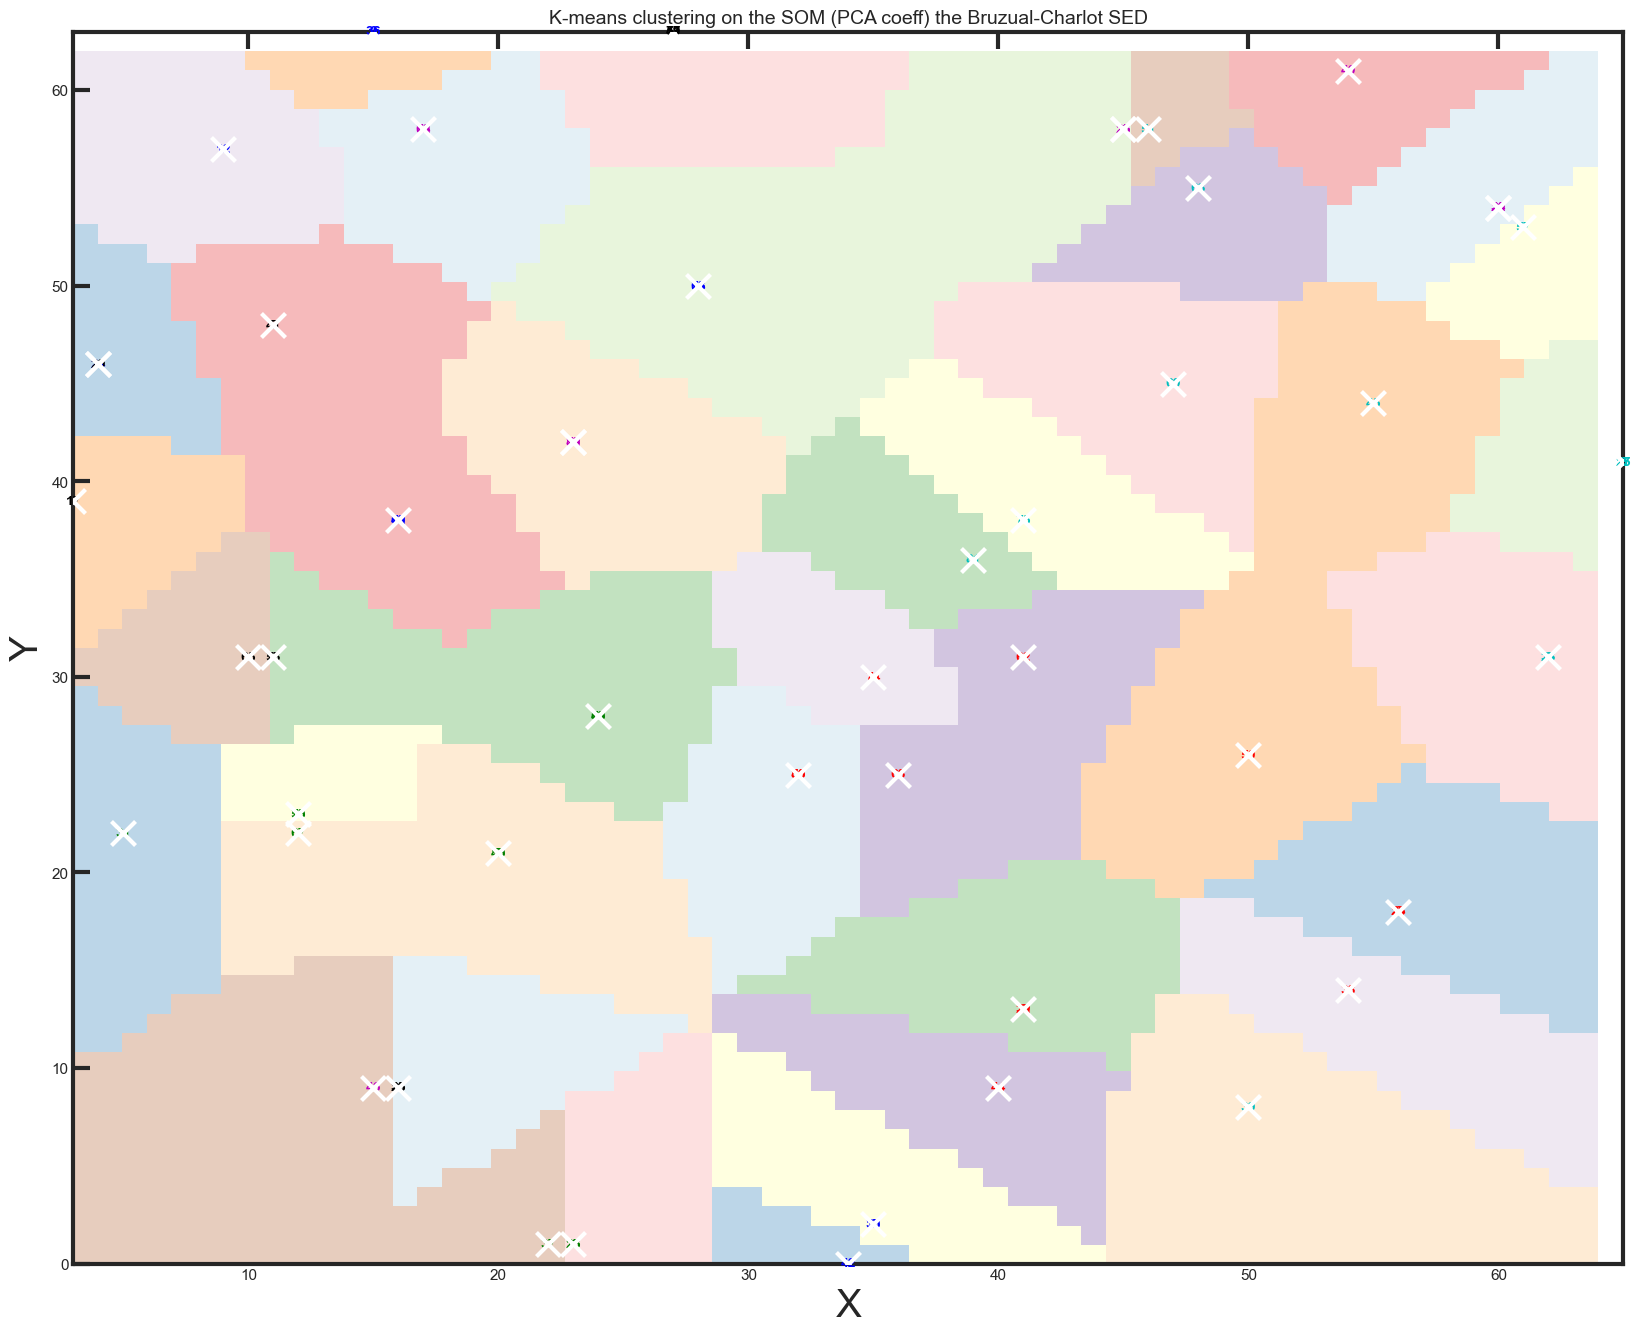

In [25]:
cycol = cycle('bgrcmk')

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 1.0  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X1[:, 0].min() , X1[:, 0].max() 
y_min, y_max = X1[:, 1].min() , X1[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(20,16))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",alpha=0.3
)

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

for cnt in range(N):
    the_num=int(all_numbers[cnt])
    plt.text(X1[cnt, 0],X1[cnt, 1],the_num, color=next(cycol),ha="center", va="center",fontsize=10,fontweight="bold")




# Plot the centroids as a white X
centroids = km.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=300,
    linewidths=3,
    color="w",
    zorder=10,
)

the_title = f"K-means clustering on the SOM (PCA coeff) the {the_filename_label} SED" 
plt.title(the_title,fontsize=14)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.xlabel("X")
plt.ylabel("Y")
#plt.xticks(())
#plt.yticks(())
plt.show()

### Plot Groups of Spectra

In [26]:
# n_clu
ncols = 2
nrows = n_clu//ncols 
if n_clu/ncols> nrows:
    nrows+=1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_22618/269704100.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

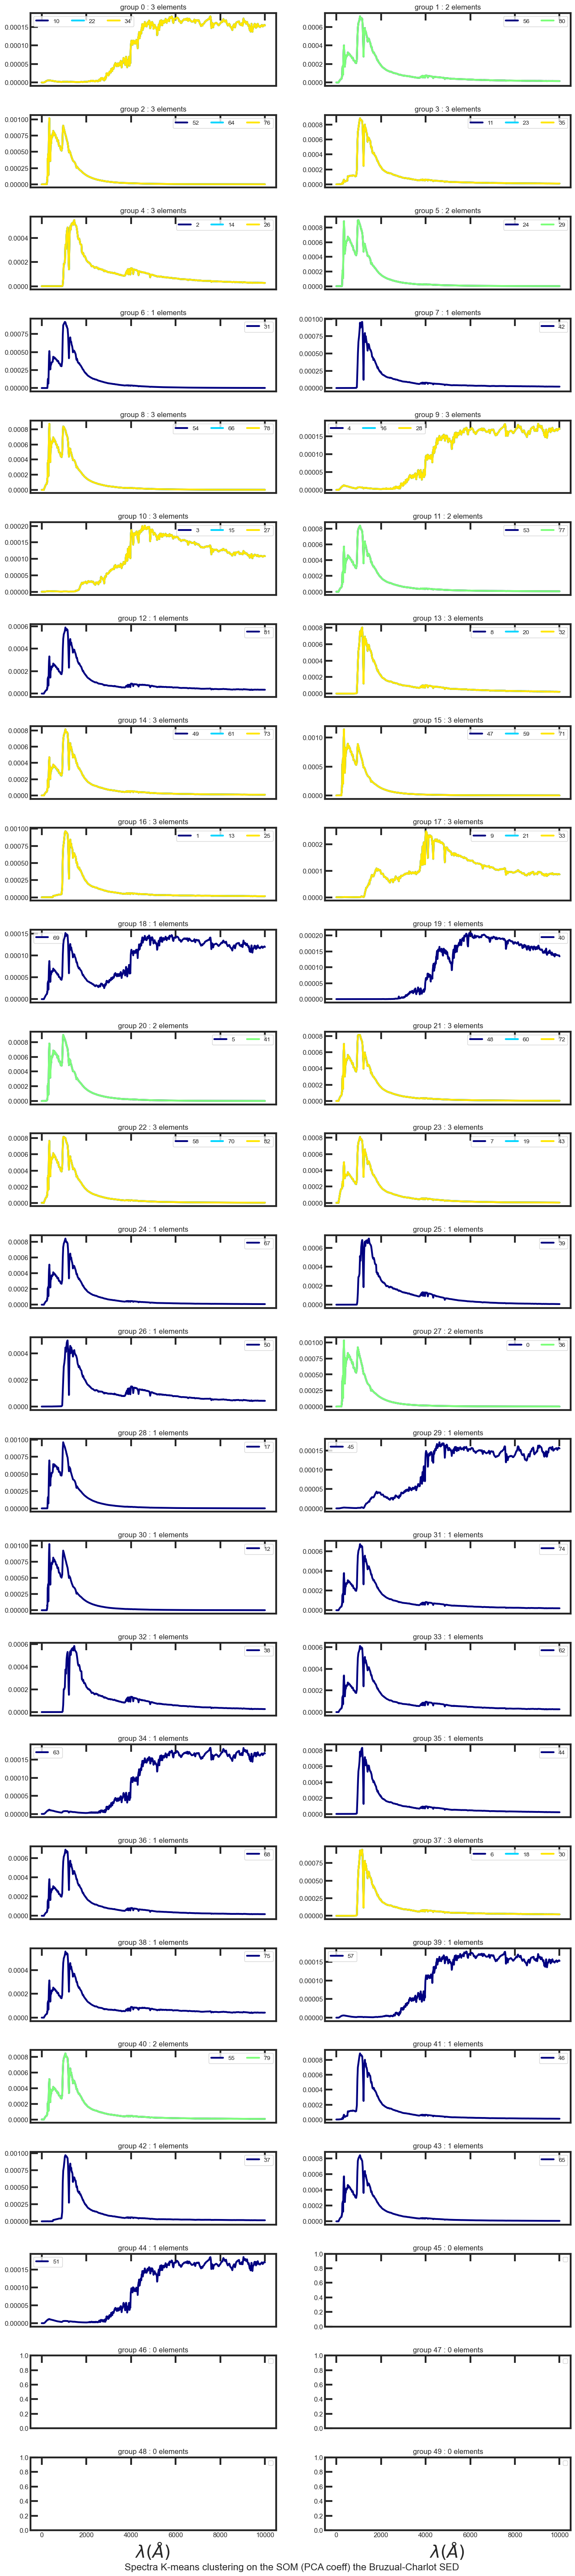

In [33]:

if ncols==2:
    fig = plt.figure(figsize=(16,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
elif ncols==4:
    fig = plt.figure(figsize=(20,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
elif ncols==1:
    fig = plt.figure(figsize=(10,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
else:
    fig = plt.figure(figsize=(20,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
    
    
#axs  = gs.subplots(sharex='col', sharey='row')
axs  = gs.subplots(sharex='col')

for icluster in range(km.n_clusters):
    
    irow=icluster//ncols
    icol=icluster-irow*ncols
    
    
    the_group = mydict[icluster]

    NTOPLOT=len(the_group)
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
    
    icount=0
    for idx in the_group:
        the_num=all_numbers[idx]
        the_label=f"{the_num:.0f}"
        axs[irow,icol].plot(wavelengths,spec[idx,:],color=all_colors[icount],label=the_label)
        icount+=1
        
    axs[irow,icol].set_title(f"group {icluster} : {NTOPLOT} elements")
    if irow==nrows-1:
        axs[irow,icol].set_xlabel("$\lambda (\AA)$ ")
    axs[irow,icol].legend(loc="best",ncol=5,fontsize=10)

the_title = f"Spectra K-means clustering on the SOM (PCA coeff) the {the_filename_label} SED" 
plt.suptitle(the_title,fontsize=16,y=1)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


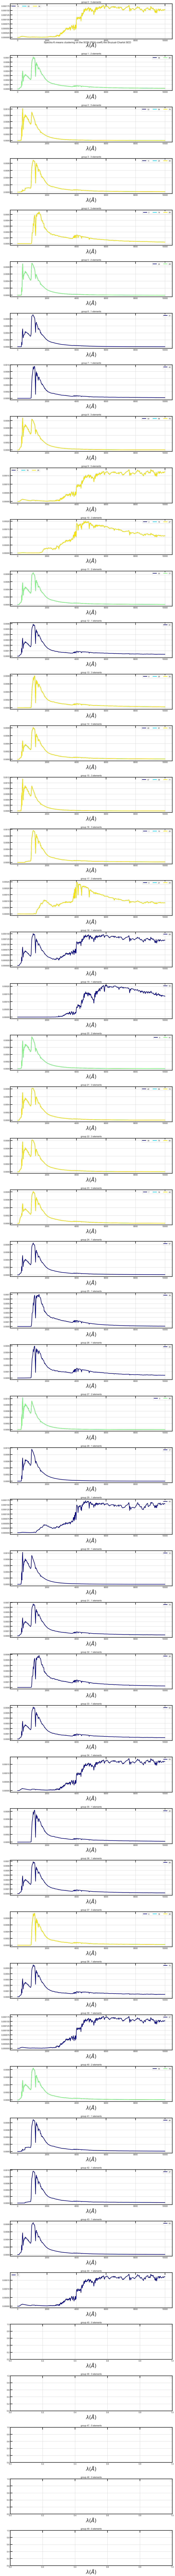

In [28]:
fig = plt.figure(figsize=(14, km.n_clusters*4))

for icluster in range(km.n_clusters):
    ax=fig.add_subplot(km.n_clusters,1,1+icluster)
    
    the_group = mydict[icluster]

    NTOPLOT=len(the_group)
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
    
    icount=0
    for idx in the_group:
        the_num=all_numbers[idx]
        the_label=f"{the_num:.0f}"
        ax.plot(wavelengths,spec[idx,:],color=all_colors[icount],label=the_label)
        icount+=1
    ax.set_title(f"group {icluster} : {NTOPLOT} elements")
    ax.set_xlabel("$\lambda (\AA)$ ")
    ax.legend(loc="best",ncol=10,fontsize=10)
    ax.grid()
        
        

the_title = f"Spectra K-means clustering on the SOM (PCA coeff) the {the_filename_label} SED" 
plt.suptitle(the_title,fontsize=14,y=1)

plt.tight_layout()
plt.show()

## Cluster analysis : PCA on each cluster 

- Info on clustering will be saved in a dictionnary stored in a pickle file

In [29]:
if FLAG_PCA_ONCLUSTERS:
    print(FLAG_PCA_ONCLUSTERS)
else:
    assert False

True


In [30]:
out_file = f"{the_filename_tag}_SOM_onPCAcoeff_clusters_{n_clu}.pickle"

### Create main dictionnary

In [31]:
out_dictionary = {}
out_dictionary["nclu"] = n_clu
out_dictionary["wavelengths"] = wavelengths

### create sub-directionnaries for each cluster 

In [32]:
# loop on clusters
for idx_sel_group  in range(n_clu):
    
    # create cluster dictionnary
    clu_dictionary = {}
    
    # get all reative indexes of spectra
    the_group_id = mydict[idx_sel_group]
      
    N_group = len(the_group_id)
    the_spectra_of_thisgroup = spec[the_group_id,:]
    the_spectra_number_ofthisgroup=all_numbers[the_group_id]
    
    # number of spectra in this group
    clu_dictionary["nspec"]=N_group
    
    #fill the cluster dictionnary with true SL numbers
    clu_dictionary["numbers_spectra"]=the_spectra_number_ofthisgroup
    
    #prepare for PCA
    X2=copy.deepcopy(the_spectra_of_thisgroup)
    X2_mean=np.mean(X2, axis=0)
    X2-=X2_mean
    #fill the cluster dictionnary with the average spectrum
    clu_dictionary["mean_spectra"] = X2_mean
    
    Ncomp=min(N_group,5)
    pca = PCA(n_components=Ncomp)
    pca.fit(X2)
    evals = pca.explained_variance_  # eigen-values
    evals_cs = evals.cumsum() # cumulated sum
    evals_cs /= evals_cs[-1]
    
    # backup result of PCA analysis in this clu_dictionary
    clu_dictionary["ncomp"]=Ncomp
    clu_dictionary["evals"]=evals
    clu_dictionary["evals_cs"]=evals_cs
    
    #print(f"group {idx_sel_group}, n={N_group}, val=",evals," frac=",evals_cs)
    out_dictionary[idx_sel_group]  = clu_dictionary
    

/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_22618/312068334.py:32: RuntimeWarning: invalid value encountered in divide
  evals_cs /= evals_cs[-1]
/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/decomposi

ValueError: Found array with 0 sample(s) (shape=(0, 10001)) while a minimum of 1 is required by PCA.

In [ ]:
# out_dictionary

In [ ]:
with open(out_file, 'wb') as handle:
    pickle.dump(out_dictionary, handle)

In [ ]:
with open(out_file, 'rb') as handle:
    data_clu = pickle.load(handle)

In [ ]:
clu_nspec_stat = np.array([data_clu[ii]['nspec'] for ii in range(data_clu['nclu'])])
clu_evals0_stat = np.array([data_clu[ii]['evals'][0] for ii in range(data_clu['nclu'])])
clu_evals_cs0_stat = np.array([data_clu[ii]['evals_cs'][0] for ii in range(data_clu['nclu'])])

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(16,8))

ax=axs[0,0]
ax.hist(clu_nspec_stat)
ax.set_xlabel("number of spectra per cluster")

ax=axs[0,1]
ax.hist(clu_evals0_stat,bins=30)
ax.set_xlabel("Variance of PCA coeff 0  of clusters")

ax=axs[0,2]
ax.hist(clu_evals_cs0_stat,bins=30)
ax.set_xlabel("Cumulated variance fraction of PCA coeff 0 of clusters")

ax=axs[1,0]
ax.scatter(clu_nspec_stat,clu_evals0_stat,marker='o')
ax.set_ylabel("Variance of PCA coeff 0  of clusters")
ax.set_xlabel("number of spectra per cluster")

ax=axs[1,1]
ax.scatter(clu_nspec_stat,clu_evals_cs0_stat,marker='o')
ax.set_ylabel("Cumulated variance fraction of PCA coeff 0 of clusters")
ax.set_xlabel("number of spectra per cluster")

ax=axs[1,2]
ax.scatter(clu_evals0_stat,clu_evals_cs0_stat,marker='o')
ax.set_ylabel("Cumulated variance fraction of PCA coeff 0 of clusters")
ax.set_xlabel("Variance of PCA coeff 0 of clusters")

the_title = f"PCA analysis on clusters by K-means  on the SOM the {the_filename_label} SED" 
plt.suptitle(the_title,fontsize=16)

plt.tight_layout()
plt.show()

## Convergence

- Covergence stuties are quite long

In [ ]:
if not FLAG_CHECK_CONVERGENCE:
    assert False

In [ ]:
if FLAG_CHECK_CONVERGENCE:
    som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5,neighborhood_function='gaussian', random_seed=10)

    max_iter = Niter
    q_error = []
    t_error = []

    for i in range(max_iter):
        rand_i = np.random.randint(len(X))
        som.update(X[rand_i], som.winner(X[rand_i]), i, max_iter)
        q_error.append(som.quantization_error(X))
        t_error.append(som.topographic_error(X))

    plt.figure(figsize=(12,8))
    plt.plot(np.arange(max_iter), q_error, label='quantization error')
    plt.plot(np.arange(max_iter), t_error, label='topographic error')
    plt.ylabel('error')
    plt.xlabel('iteration index')
    plt.legend()
    plt.show()